In [25]:
from timeit import default_timer as timer

from matplotlib import pyplot as plt
import numpy as np
import gpflow

from reggae.gp.models import LinearResponseModel
from reggae.data_loaders import load_barenco_puma, DataHolder
from reggae.gp.options import Options
from reggae.plot.gp_plotters import Plotter

f64 = np.float64

# Linear Latent Force Model Example
Replication of the paper by Lawrence et al., 2006. https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [7]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = m_observed
f_observed = f_observed
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

display(m_df)

num_genes = m_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
τ = np.linspace(0, 12, granularity)
time = (t, τ, None)
data = DataHolder(data, noise_data, time)
options = Options()

model = LinearResponseModel(data, options)

,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL,cARP2-0hrs.CEL,cARP2-2hrs.CEL,cARP2-4hrs.CEL,...,cARP2-8hrs.CEL,cARP2-10hrs.CEL,cARP2-12hrs.CEL,cARP3-0hrs.CEL,cARP3-2hrs.CEL,cARP3-4hrs.CEL,cARP3-6hrs.CEL,cARP3-8hrs.CEL,cARP3-10hrs.CEL,cARP3-12hrs.CEL
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770,7.464445,8.611248,9.255834,...,8.149388,9.367364,9.342251,7.353484,7.665469,9.798868,9.345199,8.757635,8.357981,9.026733
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658,4.649182,5.926949,7.346142,...,4.659069,6.772798,7.005289,5.204797,4.139740,8.056000,7.122196,5.633847,4.488936,5.724764
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659,3.828976,6.362601,7.576429,...,5.897853,6.975229,7.280981,4.822874,5.389953,7.749164,7.387181,6.083331,6.024036,6.771154
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770,-0.094250,6.530376,7.910253,...,4.803834,6.971544,6.890152,1.397808,6.120564,8.724741,7.821537,6.483512,5.945312,6.653475
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910,6.613610,7.371426,7.885798,...,6.658747,7.583440,7.503870,6.158661,6.178353,8.384142,7.993519,7.102504,6.990250,7.327648


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [10]:
def objective_closure():
    ret = - model.log_marginal_likelihood()
    return ret

def fit(maxiter=50):
    opt = gpflow.optimizers.Scipy()
    start = timer()
    opt_logs = opt.minimize(objective_closure,
                            model.trainable_variables,
                            options=dict(maxiter=maxiter, disp=True, eps=0.00000001),
                            method='CG')  # CG: 27.0
    end = timer()
    print(f'Time taken: {(end - start):.04f}s')
    return opt_logs

         Current function value: 20.025842
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 19
Time taken: 43.9450s


     fun: 20.02584191301561
     jac: array([-0.63854122,  0.52919693,  1.63897778, -0.19493821, -1.76954132,
        0.81832921, -0.81691384, -2.16422462,  0.59383539,  2.26429964,
        0.52553205, -0.66787943,  1.22744434,  0.49404128,  1.17191193,
        0.45976883,  1.12742497,  0.01146516, -0.18460583,  0.00755963,
       -0.12478788,  0.13231027,  0.05393482])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 19
     nit: 10
    njev: 19
  status: 1
 success: False
       x: array([ 2.1167486 ,  2.20384391,  2.30767789,  2.53082803,  2.24656524,
        1.31363077,  0.92526085,  1.15786667,  0.15674887,  1.39660275,
        2.64462037,  2.08294313, -2.63216968, -2.92255707, -2.93207246,
       -2.85002531, -3.13303299, -8.92890187, -0.06105316, -0.9936835 ,
       -1.01817153, -2.12853038, -0.57588465])

In [9]:
fit(10)


In [19]:
plotter = Plotter(data, model, m_df.columns)

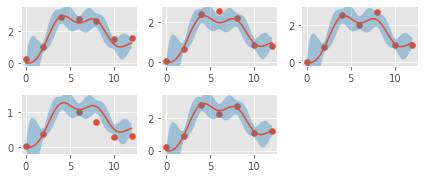

In [27]:
plt.figure(figsize=(6, 6))
plotter.plot_genes(τ)
plotter.plot_tf(τ);